In [1]:
#| hide

%load_ext autoreload
%autoreload 2

# DiffPaSS – Example usage on datasets of interacting protein systems

> DiffPaSS and DiffPaSS-IPA for pairing two interacting MSAs using mutual information.

In [2]:
# Stdlib imports
from collections import defaultdict
from typing import Optional

# NumPy
import numpy as np

# PyTorch
import torch

# Plotting
from matplotlib import pyplot as plt

# Set the number of threads for PyTorch
torch.set_num_threads(8)

# Device
DEVICE = torch.device(
    f"cuda{(':' + input('Enter the CUDA device number:')) if torch.cuda.device_count() > 1 else ''}"
    if torch.cuda.is_available() else "cpu"
)
# DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

# Set the seeds for NumPy and PyTorch
NUMPY_SEED = 42
np.random.seed(NUMPY_SEED)

TORCH_SEED = 42
torch.manual_seed(TORCH_SEED);

Using device: cuda


## 1. Load the prokaryotic interacting MSAs

Two interacting sequence datasets are available: HK-RR and MALG-MALK.

`group_name_func` extracts group names (i.e. species names) from the FASTA header.  

In [3]:
# DiffPaSS parsing and preprocessing utilities
from diffpass.msa_parsing import read_msa
from diffpass.data_utils import create_groupwise_seq_records, fetch_seq_records_from_group_names, seq_records_tokenizer, compute_num_correct_pairings


# Load prokaryotic datasets

msa_data = [
    read_msa("../data/HK-RR/HK_in_Concat_nnn.fasta", -1),
    read_msa("../data/HK-RR/RR_in_Concat_nnn.fasta", -1)
]
group_name_func = lambda header: header.split("|")[1]

# msa_data = [
#     read_msa("../data/MALG-MALK/MALG_cov75_hmmsearch_extr5000_withLast_b.fasta", -1),
#     read_msa("../data/MALG-MALK/MALK_cov75_hmmsearch_extr5000_withLast_b.fasta", -1)
# ]
# group_name_func = lambda header: header.split("_")[-1]

## 2. Create two pairable multiple sequence alignments (MSAs) and tokenize them

We pick all sequences from 50 species picked uniformly at random from the datasets. This yields two pairable MSAs, each with 581 sequences. Species with only one sequence are removed.

In [4]:
msa_data_species_by_species = [
    create_groupwise_seq_records(msa, group_name_func, remove_groups_with_one_seq=True) 
    for msa in msa_data
]
all_species = list(msa_data_species_by_species[0])
assert all_species == list(msa_data_species_by_species[1])

n_species_to_sample = 50
species = np.random.choice(all_species, n_species_to_sample, replace=False)

In [5]:
msa_data_and_species_sizes = [
    fetch_seq_records_from_group_names(msa_species_by_species, species)
    for msa_species_by_species in msa_data_species_by_species
]

species_sizes = msa_data_and_species_sizes[0]["group_sizes"]
print(f"Species sizes: {species_sizes}")

n_seqs = sum(species_sizes)
print(f"Number of pairable sequences in this selection: {n_seqs}")

Species sizes: [3, 21, 7, 20, 21, 14, 25, 2, 7, 15, 6, 6, 6, 17, 6, 22, 10, 13, 4, 15, 14, 8, 15, 14, 11, 19, 14, 2, 21, 19, 30, 2, 27, 7, 9, 22, 2, 6, 14, 17, 3, 6, 2, 9, 13, 19, 3, 9, 2, 2]
Number of pairable sequences in this selection: 581


In [6]:
x = seq_records_tokenizer(msa_data_and_species_sizes[0]["seq_records"], device=DEVICE)
y = seq_records_tokenizer(msa_data_and_species_sizes[1]["seq_records"], device=DEVICE)

## 3. Optimize pairings by maximising mutual information between chains: ``InformationAlignment``

In [7]:
from diffpass.train import InformationPairing


# Optimization parameters for DiffPaSS bootstrap
bootstrap_cfg = {
    "n_start": 1,
    "n_end": None,
    "step_size": 1,  # Increase to speed up if needed
    "show_pbar": True,
    "single_fit_cfg": None  # Default
}

In [8]:
information_pairing = InformationPairing(group_sizes=species_sizes).to(DEVICE)

bootstrap_results = information_pairing.fit_bootstrap(x, y, **bootstrap_cfg)

 99%|██████████████████████████████████▌| 572/579 [00:34<00:00, 16.75it/s]


## 4. Plot the results: hard losses and fraction of correct pairings

In [9]:
# Ground truth hard loss
target_hard_loss = information_pairing.compute_losses_identity_perm(x, y)["hard"]

In [10]:
def plot_hard_losses_and_frac_correct(
    results,
    target_hard_loss: Optional[float] = None
):
    hard_losses = [
        min(hard_losses_this_step)
        for hard_losses_this_step in results.hard_losses
    ]
    frac_correct = [
        compute_num_correct_pairings(
            hard_perms_this_step[np.argmin(hard_losses_this_step)],
            compare_to_identity_permutation=True
        ) / n_seqs
        for hard_perms_this_step, hard_losses_this_step in zip(results.hard_perms, results.hard_losses)
    ]

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(hard_losses, label="DiffPaSS hard permutation")
    axs[0].axhline(target_hard_loss, color="red", label=f"Ground truth loss (identity) = {target_hard_loss:.4f}")
    axs[0].set_ylabel("Hard loss")
    axs[0].set_xlabel("Bootstrap iteration")
    axs[0].set_title(f"Minimum loss during optimization: {np.min(hard_losses):.4f}")
    axs[0].legend()

    axs[1].plot(frac_correct)
    axs[1].set_ylabel("Fraction of correct pairings")
    axs[1].set_xlabel("Bootstrap iteration")
    axs[1].set_title(f"Percentage of correct pairings at loss minimum: {frac_correct[np.argmin(hard_losses)] * 100:.1f}")

    plt.show()

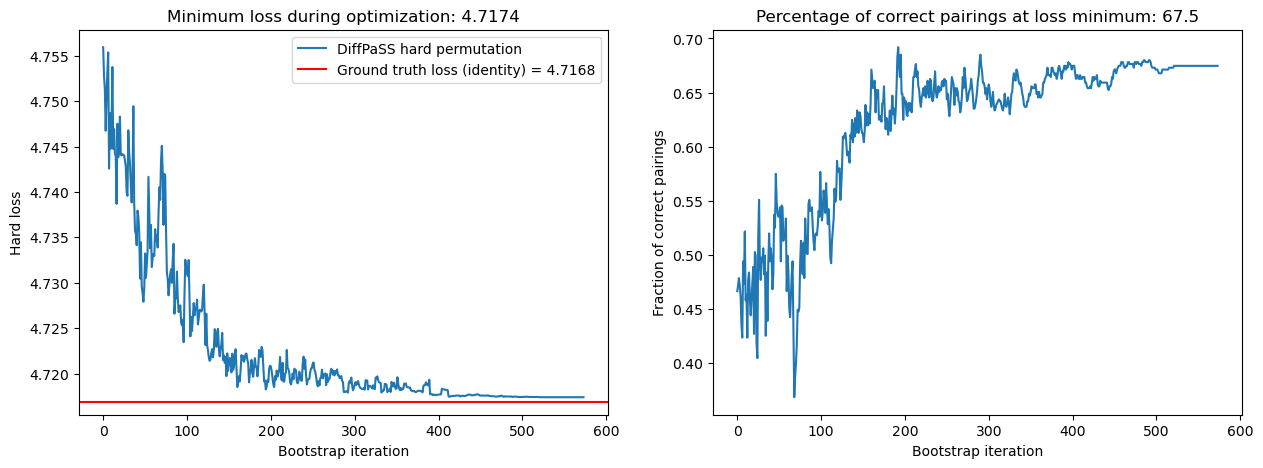

In [11]:
plot_hard_losses_and_frac_correct(bootstrap_results, target_hard_loss=target_hard_loss)

## 4. Using robustly predicted pairs to bootstrap again! Iterative Pairing Algorithm (IPA)

In [12]:
from diffpass.ipa_utils import get_robust_pairs

robust_pairs = get_robust_pairs(
    bootstrap_results.hard_perms,
    cutoff=1.  # Decrease to consider more pairs as robust
)


def print_robust_pairs_stats(robust_pairs):
    n_robust_pairs = sum(len(robust_pairs_this_species) for robust_pairs_this_species in robust_pairs)
    frac_pairs_robust = n_robust_pairs / n_seqs
    print(f"Percentage of all predicted pairs that are robust: {frac_pairs_robust * 100:.1f}%", flush=True)
    
    frac_robust_pairs_correct = sum(
        [pair[0] == pair[1] for robust_pairs_this_species in robust_pairs for pair in robust_pairs_this_species]
    ) / n_robust_pairs
    print(f"Percentage of robust pairs that are correct pairs: {frac_robust_pairs_correct * 100:.1f}%", flush=True)

In [13]:
print_robust_pairs_stats(robust_pairs)

Percentage of all predicted pairs that are robust: 9.6%
Percentage of robust pairs that are correct pairs: 100.0%


Every robust pair is correct!  We can exploit this to start another DiffPaSS bootstrap with these pairs as fixed pairings.  And then repeat the process to obtain more robust pairs, and so on.  Let's run this process 4 times, so that we will have run 5 DiffPaSS optimizations in total.

DiffPaSS-IPA: run 2


 98%|██████████████████████████████████▍| 515/523 [00:31<00:00, 16.19it/s]


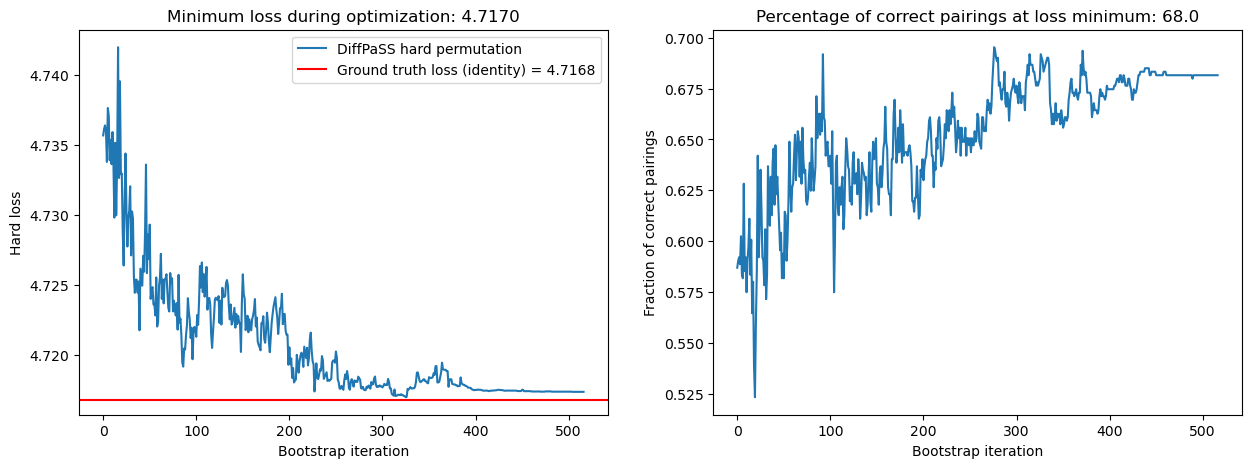

Percentage of all predicted pairs that are robust: 33.0%
Percentage of robust pairs that are correct pairs: 100.0%

DiffPaSS-IPA: run 3


 97%|██████████████████████████████████ | 377/387 [00:22<00:00, 16.51it/s]


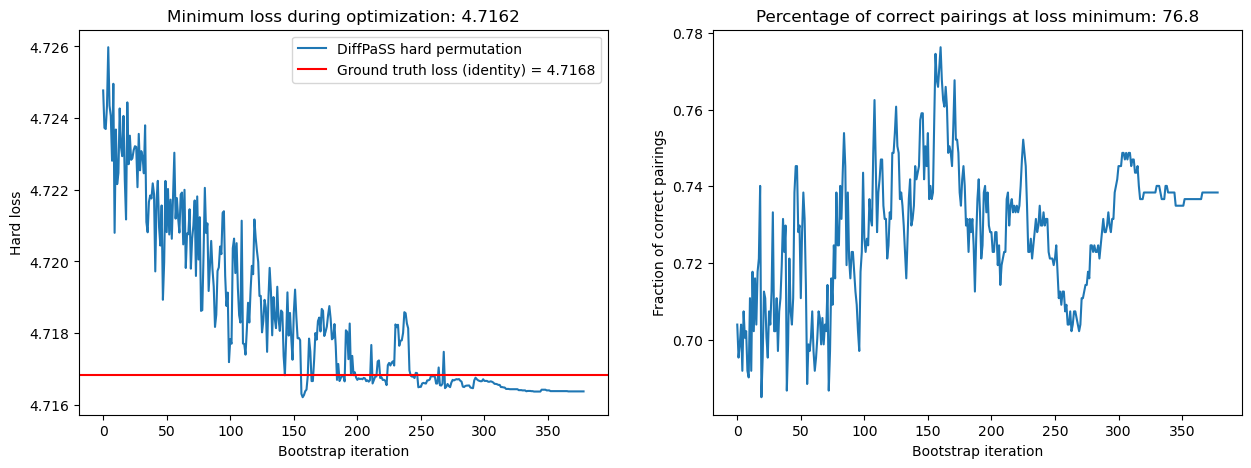

Percentage of all predicted pairs that are robust: 52.7%
Percentage of robust pairs that are correct pairs: 99.3%

DiffPaSS-IPA: run 4


 99%|██████████████████████████████████▌| 270/273 [00:15<00:00, 17.80it/s]


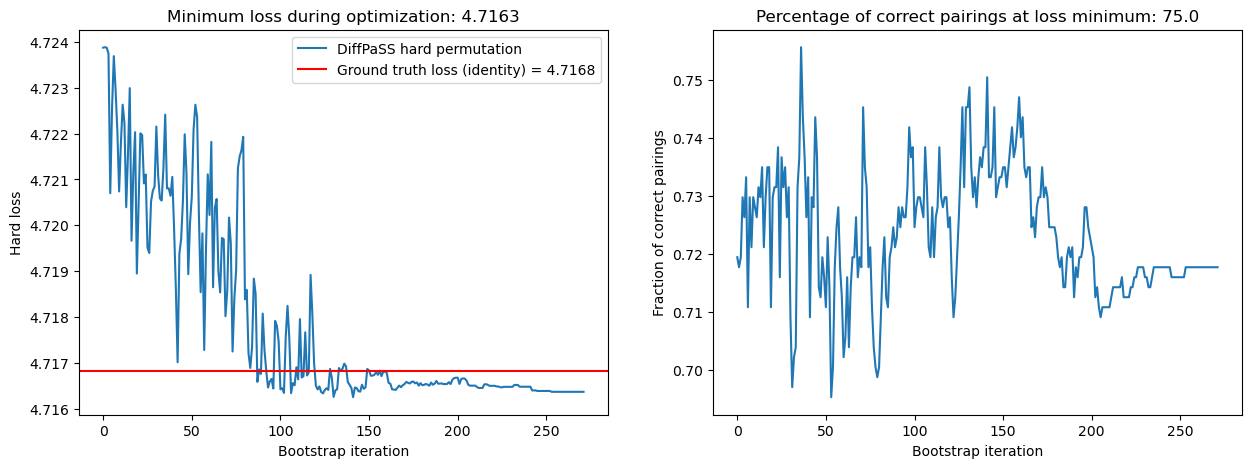

Percentage of all predicted pairs that are robust: 60.1%
Percentage of robust pairs that are correct pairs: 98.0%

DiffPaSS-IPA: run 5


 98%|██████████████████████████████████▏| 225/230 [00:12<00:00, 18.24it/s]


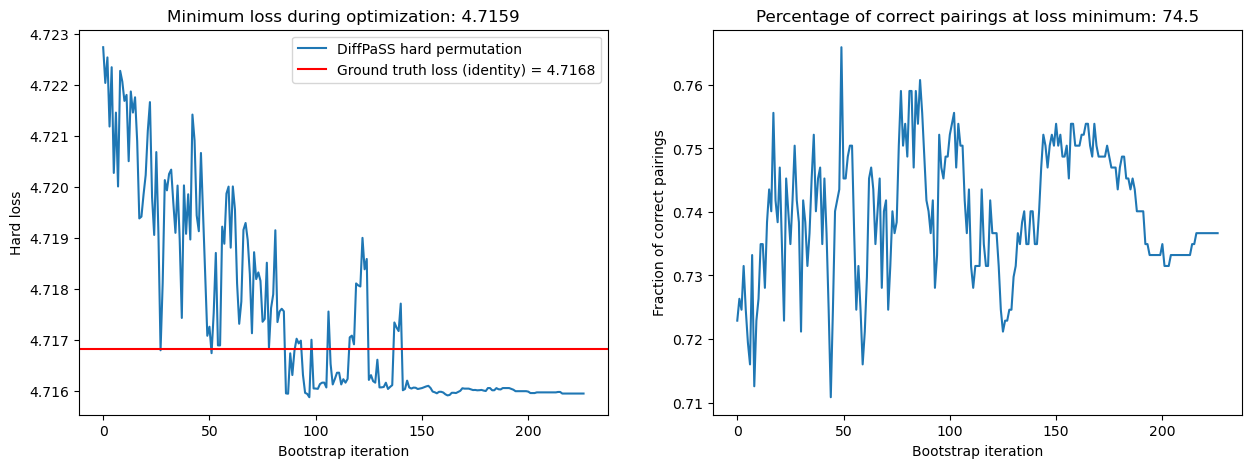

Percentage of all predicted pairs that are robust: 65.2%
Percentage of robust pairs that are correct pairs: 94.2%



In [14]:
n_ipa_runs = 4

for ipa_idx in range(2, n_ipa_runs + 2):
    print(f"DiffPaSS-IPA: run {ipa_idx}")
    fixed_pairings = robust_pairs
    information_pairing = InformationPairing(group_sizes=species_sizes, fixed_pairings=fixed_pairings).to(DEVICE)

    bootstrap_results = information_pairing.fit_bootstrap(x, y, **bootstrap_cfg)
    plot_hard_losses_and_frac_correct(bootstrap_results, target_hard_loss=target_hard_loss)

    robust_pairs = get_robust_pairs(bootstrap_results.hard_perms, cutoff=1.)
    print_robust_pairs_stats(robust_pairs)
    print()

By running DiffPaSS-IPA a total of 5 times, we have obtained a large set of robust pairs (65.2% of all possible pairs!), 94.2% of which are correct.

We have also decreased the hard losses and simultaneously increased the overall percentage of correct pairs, from 68.0% at the first IPA step to 74.5% at the last.

The lowest hard losses obtained by DiffPaSS-IPA for this dataset and these choices of random seeds are actually slightly lower than the ground truth hard loss, which suggests that the optimization has converged to a good solution.